# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Filter-kernels" data-toc-modified-id="Filter-kernels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filter kernels</a></div><div class="lev1 toc-item"><a href="#Static-nonlinearity" data-toc-modified-id="Static-nonlinearity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Static nonlinearity</a></div><div class="lev1 toc-item"><a href="#Saccade-cell-signals" data-toc-modified-id="Saccade-cell-signals-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Saccade cell signals</a></div><div class="lev1 toc-item"><a href="#Optimotor-signal" data-toc-modified-id="Optimotor-signal-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Optimotor signal</a></div><div class="lev1 toc-item"><a href="#Motoneuron-processing" data-toc-modified-id="Motoneuron-processing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Motoneuron processing</a></div><div class="lev2 toc-item"><a href="#input-integration" data-toc-modified-id="input-integration-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>input integration</a></div><div class="lev1 toc-item"><a href="#Make-figure-7" data-toc-modified-id="Make-figure-7-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Make figure 7</a></div>

In [1]:
import sys
sys.path.append('/media/analysis-code/figurefirst/')

# Introduction
This contains the code used to generate the summary diagram in figure 7. The quantitative details of the model are provided to help clarify our conception and are intended to show that a simple linear-nonlinear poisson cascade model is plausible such that it: 

1. is sufficient to recapitulate many of the phenomena that we observe in our experiments 
2. is built from well established neuronal computations 
3. incorporates recent observations on the descending inputs into the motor system
    
The parameters of the model were selected by hand for illustrative purposes. Estimating these parameters from the data or validating this model against all other possible formulations is beyond the scope of this study, though we believe such a model is testable in future experiments.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png' 
import pylab as plb
import numpy as np
import scipy as sp
import figurefirst as fifi
import plotfuncs as plf
from numpy import random
plb.rcParams['font.size'] =  9
plb.rcParams['pdf.fonttype'] = 42
plb.rcParams['image.interpolation'] = 'nearest'
plb.rcParams['image.aspect'] = 'auto'
plb.rcParams['image.cmap'] = 'BrBG'
demo_mode = True
if demo_mode:
    random.seed(2)

In [3]:
# Timebase
xi = np.linspace(-20,20,40000) #times
sf = 40000/40.0 #sampling frequency
step = ((xi>0) & (xi<3)).astype(float) #motion stimulus
# the plot range
rng = ((xi>-3) & (xi<6))

# Filter kernels

Although there are likely many filters, we are just modeling two phenomena. The first is a very slow process represents the optimotor integrator (red kernel below). The second, faster process (green) represents the filtering by the calcium dynamics of the muscle. GcAMP dynamics are not included in this model.

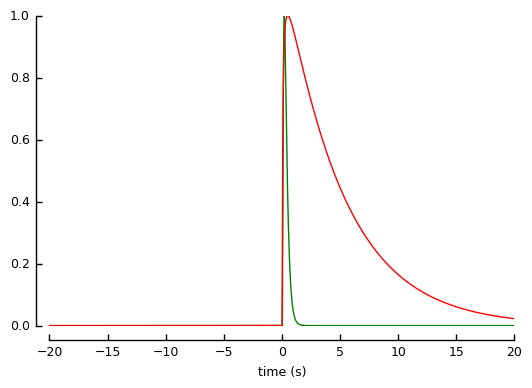

In [4]:
def make_kernel(tauon,tauoff):
    kx = np.linspace(0.1,20000,10000)
    kon = lambda x:np.exp(((-1*tauon)/(x)))
    koff = lambda x:np.exp((-1*x)/tauoff)
    k = (kon(kx)*koff(kx)/np.max(kon(kx)*koff(kx)))
    k = np.hstack((np.zeros_like(k),k)) #acausal
    return k

sk = make_kernel(50,5000) #slow kernal (optimotor integrator)
mk = make_kernel(200.0,200.0) #muscle kernel -- calcium and GcAMP

plb.plot(np.linspace(-20,20,20000),mk,'g')
plb.plot(np.linspace(-20,20,20000),sk,'r')
plb.gca().set_xlabel('time (s)')
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])

# Static nonlinearity

The tonic and phasic muscles have a sharper and higher activation threshold than the tonic muscles, modeled by differences in the static non-linearity

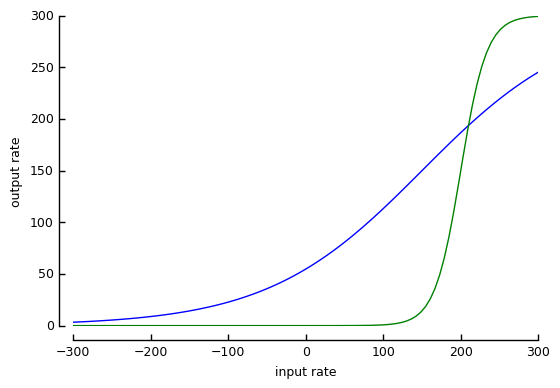

In [5]:
#muscle firing rate can range from 0 to 300 Hz
sigmoid_t = lambda x: 300/(1+np.exp(-0.01*(x - 150))) #tonic squashing function
sigmoid_p = lambda x: 300/(1+np.exp(-0.06*(x - 200))) #phasic squashing function
inp = np.linspace(-300,300,100) #plot example sigmoid
plb.plot(inp,sigmoid_t(inp))
plb.plot(inp,sigmoid_p(inp))
plb.gca().set_ylabel('output rate')
plb.gca().set_xlabel('input rate')
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])

# Saccade cell signals

The signal from the descending pathways carrying the saccade command is modeled as two poisson processes with a rate that depends on the presence or absence of motion. In this model we have not modeled any dependence on statistics of the motion (speed, direction, frequency content ect..)

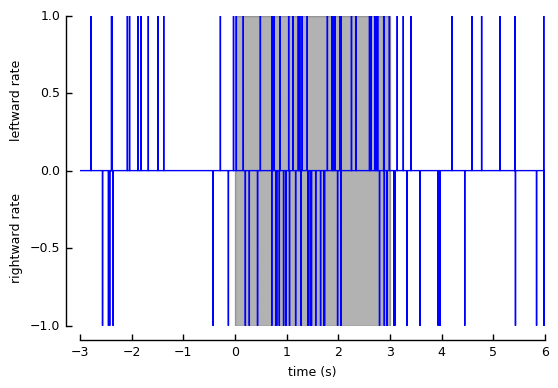

In [6]:
# create a common saccade trigger signal as the sum
# of a positive and negative poisson process
BK_RATE = 3.0 # background rate
MOTION_RATE = 5.0 # rate during the motion epoch
n_common = np.random.poisson((step*MOTION_RATE+BK_RATE)/sf)
n_common -= np.random.poisson((step*MOTION_RATE+BK_RATE)/sf)
plb.axvspan(0,3,color = 'k',alpha = 0.3)
plb.plot(xi[rng],n_common[rng])
plb.gca().set_ylabel('rightward rate             leftward rate')
plb.gca().set_xlabel('time (s)')
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])

# Optimotor signal

The signal from the optimotor pathway is a signed signal that depends on the direction of motion, in this case it is positive for leftward motion.

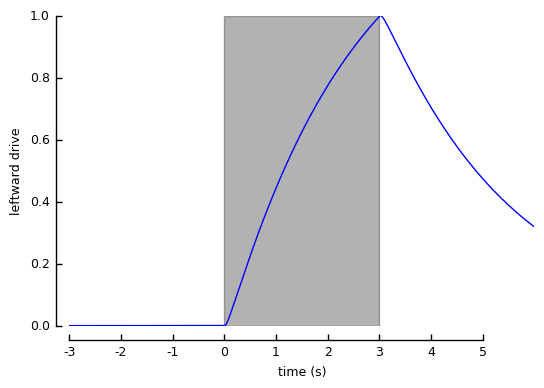

In [7]:
# create common integrated optomotor signal by convovling the motion step with the 
# slow kernel
integrate = np.convolve(sk,step,mode = 'same')
integrate /= max(integrate)
plb.axvspan(0,3,color = 'k',alpha = 0.3)
plb.plot(xi[rng],integrate[rng])
#plb.plot(xi[rng],-1*integrate[rng])
plb.gca().set_ylabel('leftward drive')
plb.gca().set_xlabel('time (s)')
plb.gca().set_xticks(np.arange(-3,6))
plb.gca().set_xticklabels(np.arange(-3,6))
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])

# Motoneuron processing

The motor unit activation signal is a modeled by summing the descending signals, passing them through a static non-linearity that determines the time-varying rate of another poisson process that represents the motor neuron firing rate. This firing rate is then filtered by the muscle calcium dynamics.

First, the motor units recieve input from the tonic and phasic signals. A gain and steady bias is applied to each of these signals. The fact that the tonic motor units are normally active is modeled by using a higher bias value, however, note that the gain terms applied to the inputs are identical for the tonic and phasic units. Thus the two types of motor units 
only differ in terms of the mean level of activity and the form of the static non-linearity. The muscle array is represented by four types of motor units for each wing: a phasic and tonic unit for the muscles associated with increases in stroke amplitude (blue), and a phasic and tonic unit for the muscles associated with a decrease in stroke amplitude (green). The ampup and ampdown muscles differ in that the polarity of the inputs are reversed. The input rates for the muscles attached to the right wing are shown below.

## input integration
We integrate the optomotor and saccade signal and use it to create an inhomogeneous poisson process that determines each motor unit's firing rate signals are intended to represent the motoneuron epsc's we have not passed the signals though a synaptic kernel for simplicity. Indeed, we probably would want to inlcude a sinusodal forcing function to represent mechanosensory feedback from the wing and haltere. 

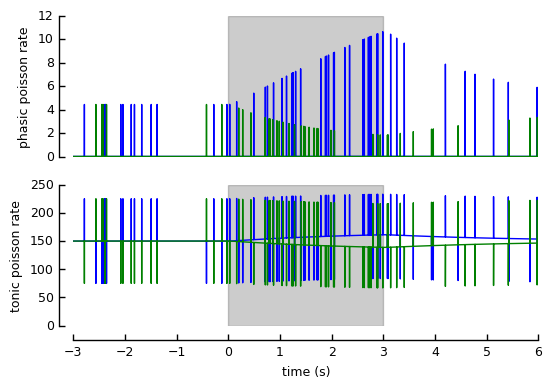

In [8]:
TONIC_BCK = 150 # background input from the tonic channels
PHASIC_BCK = 20 # background input from the phasic channels

INT_GAIN = 15 # Gain applied to the integrator input
SAC_GAIN = 110 # Gain applied to the saccade input


rwing_phasic_ampup_in = sigmoid_p(integrate*INT_GAIN + n_common*SAC_GAIN + PHASIC_BCK)
rwing_phasic_ampdown_in = sigmoid_p(-1*integrate*INT_GAIN - n_common*SAC_GAIN + PHASIC_BCK)
lwing_phasic_ampup_in = sigmoid_p(-1*integrate*INT_GAIN - n_common*SAC_GAIN + PHASIC_BCK)
lwing_phasic_ampdown_in = sigmoid_p(integrate*INT_GAIN + n_common*SAC_GAIN + PHASIC_BCK)

rwing_tonic_ampup_in = sigmoid_t(integrate*INT_GAIN + n_common*SAC_GAIN + TONIC_BCK )
rwing_tonic_ampdown_in = sigmoid_t(-1*integrate*INT_GAIN - n_common*SAC_GAIN + TONIC_BCK )
lwing_tonic_ampup_in = sigmoid_t(-1*integrate*INT_GAIN - n_common*SAC_GAIN + TONIC_BCK )
lwing_tonic_ampdown_in = sigmoid_t(integrate*INT_GAIN + n_common*SAC_GAIN + TONIC_BCK )

plb.subplot(2,1,1)
plb.plot(xi[rng],rwing_phasic_ampup_in[rng])
plb.plot(xi[rng],rwing_phasic_ampdown_in[rng])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
plb.gca().set_ylabel('phasic poisson rate')
fifi.mpl_functions.adjust_spines(plb.gca(),['left'])

plb.subplot(2,1,2)
plb.plot(xi[rng],rwing_tonic_ampup_in[rng])
plb.plot(xi[rng],rwing_tonic_ampdown_in[rng])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
plb.gca().set_ybound(0,250)
plb.gca().set_ylabel('tonic poisson rate')
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])
lbl = plb.gca().set_xlabel('time (s)')

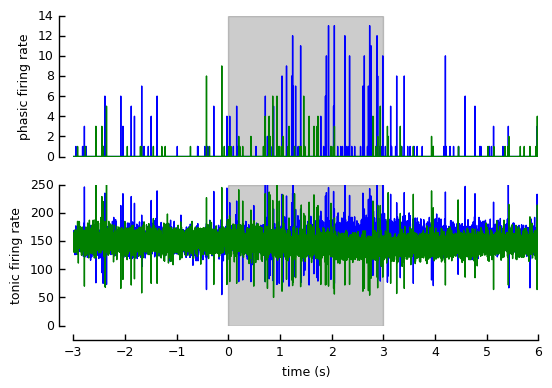

In [9]:
# 
rwing_phasic_ampup_f = np.random.poisson(rwing_phasic_ampup_in)
rwing_phasic_ampdown_f = np.random.poisson(rwing_phasic_ampdown_in)
lwing_phasic_ampup_f = np.random.poisson(lwing_phasic_ampup_in)
lwing_phasic_ampdown_f = np.random.poisson(lwing_phasic_ampdown_in)


rwing_tonic_ampup_f = np.random.poisson(rwing_tonic_ampup_in)
rwing_tonic_ampdown_f = np.random.poisson(rwing_tonic_ampdown_in)
lwing_tonic_ampup_f = np.random.poisson(lwing_tonic_ampup_in)
lwing_tonic_ampdown_f = np.random.poisson(lwing_tonic_ampdown_in)

plb.subplot(2,1,1)
plb.plot(xi[rng],rwing_phasic_ampup_f[rng])
plb.plot(xi[rng],rwing_phasic_ampdown_f[rng])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
fifi.mpl_functions.adjust_spines(plb.gca(),['left'])
plb.gca().set_ylabel('phasic firing rate')
#plf.pull_ax_spines()

#plb.gca().set_xbound(0,0.2)
plb.subplot(2,1,2)
plb.plot(xi[rng],rwing_tonic_ampup_f[rng])
plb.plot(xi[rng],rwing_tonic_ampdown_f[rng])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
plb.gca().set_ylabel('tonic firing rate')
plb.gca().set_ybound(0,250)
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])
lbs = plb.gca().set_xlabel('time (s)')
#plf.pull_ax_spines()

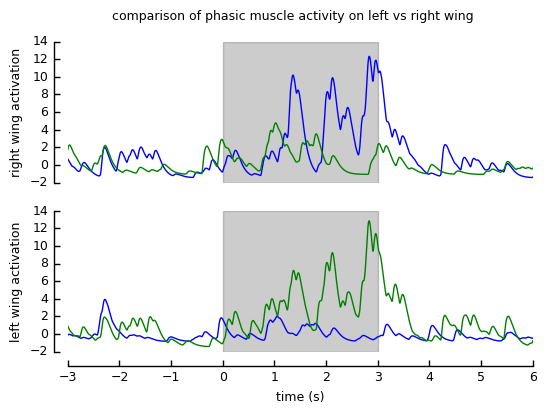

In [10]:
# to create the calcium signals we pass the muscle firing rates through the 'muscle kernel'
ca_sigs = dict()
ca_sigs[('right_wing','phasic','amp_up')] = np.convolve(mk,rwing_phasic_ampup_f,mode = 'same')
ca_sigs[('right_wing','phasic','amp_down')] = np.convolve(mk,rwing_phasic_ampdown_f,mode = 'same')
ca_sigs[('left_wing','phasic','amp_up')] = np.convolve(mk,lwing_phasic_ampup_f,mode = 'same')
ca_sigs[('left_wing','phasic','amp_down')] = np.convolve(mk,lwing_phasic_ampdown_f,mode = 'same')

ca_sigs[('right_wing','tonic','amp_up')] = np.convolve(mk,rwing_tonic_ampup_f,mode = 'same')
ca_sigs[('right_wing','tonic','amp_down')] = np.convolve(mk,rwing_tonic_ampdown_f,mode = 'same')
ca_sigs[('left_wing','tonic','amp_up')] = np.convolve(mk,lwing_tonic_ampup_f,mode = 'same')
ca_sigs[('left_wing','tonic','amp_down')] = np.convolve(mk,lwing_tonic_ampdown_f,mode = 'same')

for sig in ca_sigs.values():
    sig -= np.mean(sig[(xi<0)&(xi>-3)])
    sig /= np.std(sig[(xi<0)&(xi>-3)])
    
plb.subplot(2,1,1)

plb.plot(xi[rng],ca_sigs[('right_wing','phasic','amp_up')][rng])
plb.plot(xi[rng],ca_sigs[('right_wing','phasic','amp_down')][rng])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
fifi.mpl_functions.adjust_spines(plb.gca(),['left'])
plb.gca().set_ylabel('right wing activation')

plb.subplot(2,1,2)
plb.plot(xi[rng],ca_sigs[('left_wing','phasic','amp_up')][rng])
plb.plot(xi[rng],ca_sigs[('left_wing','phasic','amp_down')][rng])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])
plb.gca().set_ylabel('left wing activation')
plb.gca().set_xlabel('time (s)')
lbl = plb.gcf().suptitle('comparison of phasic muscle activity on left vs right wing')

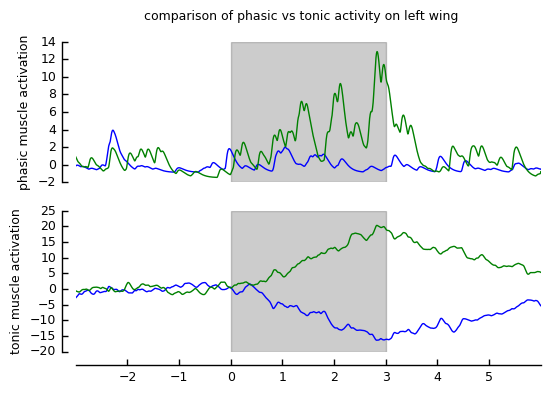

In [11]:
plb.subplot(2,1,1)
plb.plot(xi[rng],ca_sigs[('left_wing','phasic','amp_up')][rng])
plb.plot(xi[rng],ca_sigs[('left_wing','phasic','amp_down')][rng])
fifi.mpl_functions.adjust_spines(plb.gca(),['left'])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
plb.gca().set_ylabel('phasic muscle activation')

plb.subplot(2,1,2)
plb.plot(xi[rng],ca_sigs[('left_wing','tonic','amp_up')][rng])
plb.plot(xi[rng],ca_sigs[('left_wing','tonic','amp_down')][rng])
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
plb.gca().set_ylabel('tonic muscle activation')
lbl = plb.gcf().suptitle('comparison of phasic vs tonic activity on left wing')

In [12]:
rw = ca_sigs[('right_wing','tonic','amp_up')] + 1*ca_sigs[('right_wing','phasic','amp_up')] - \
            ca_sigs[('right_wing','tonic','amp_down')]-1*ca_sigs[('right_wing','phasic','amp_down')] 
    
lw = ca_sigs[('left_wing','tonic','amp_up')] + 1*ca_sigs[('left_wing','phasic','amp_up')] - \
        ca_sigs[('left_wing','tonic','amp_down')]-1*ca_sigs[('left_wing','phasic','amp_down')]
lmr = lw-rw

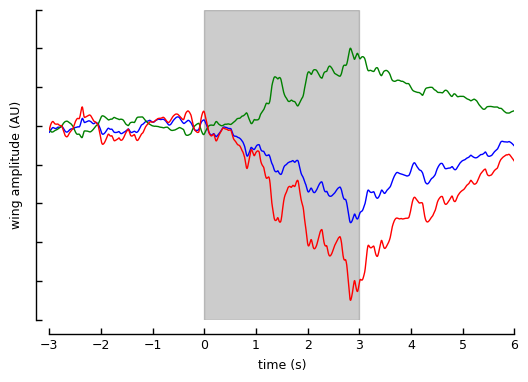

In [13]:
plb.plot(xi[rng],lw[rng])
plb.plot(xi[rng],rw[rng])
plb.plot(xi[rng],lw[rng]-rw[rng])
plb.axvspan(0,3,color = 'k',alpha = 0.2)
fifi.mpl_functions.adjust_spines(plb.gca(),['left','bottom'])
plb.gca().set_yticklabels([])
plb.gca().set_xlabel('time (s)')
lbl = plb.gca().set_ylabel('wing amplitude (AU)')

# Make figure 7

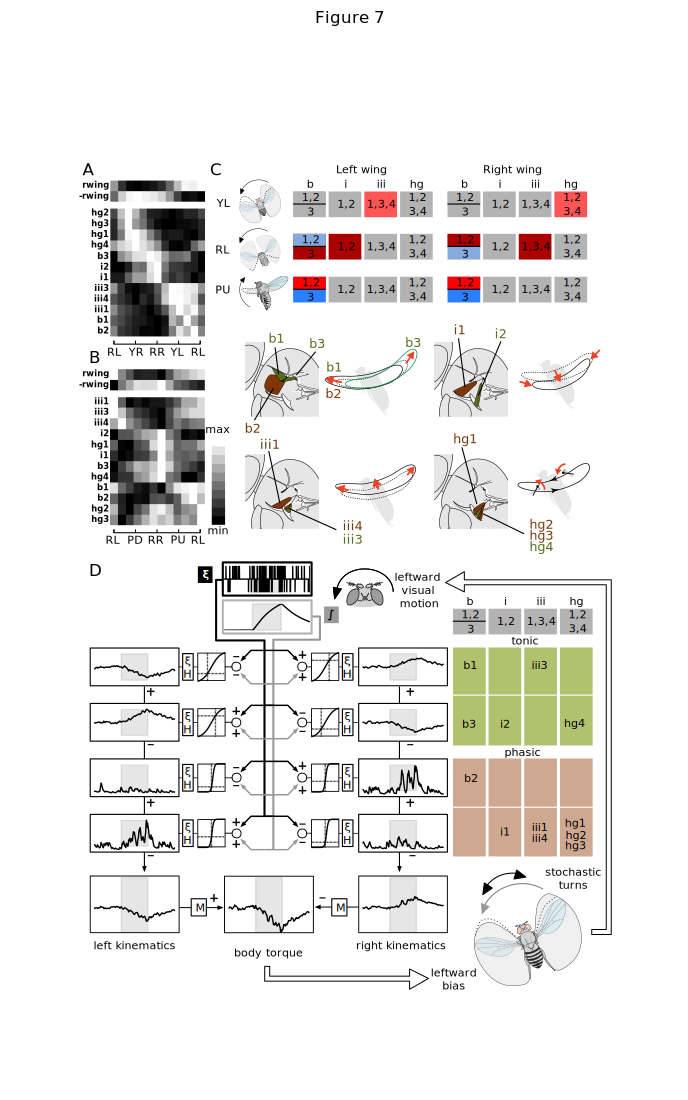

In [15]:
reload(fifi)
from matplotlib import colors
layout = fifi.FigureLayout('figure_7_layout.svg')
layout.make_mplfigures()

rng = ((xi>-3) & (xi<6))

tmax = np.max(np.hstack([ca_sigs[('left_wing','tonic','amp_up')][rng], 
                         ca_sigs[('left_wing','tonic','amp_down')][rng],
                         ca_sigs[('right_wing','tonic','amp_up')][rng],
                         ca_sigs[('right_wing','tonic','amp_down')][rng]]))

pmax = np.max(np.hstack([ca_sigs[('left_wing','phasic','amp_up')][rng], 
                         ca_sigs[('left_wing','phasic','amp_down')][rng],
                         ca_sigs[('right_wing','phasic','amp_up')][rng],
                         ca_sigs[('right_wing','phasic','amp_down')][rng]]))


for wing_key in ['left_wing','right_wing']:
    for dyn_key in ['tonic','phasic']:
        for amp_key in ['amp_up','amp_down']:
            ax = layout.axes[('model',wing_key,dyn_key,amp_key)]
            ax.plot(xi[rng],ca_sigs[(wing_key,dyn_key,amp_key)][rng],clip_on = False,color = 'k')
            if dyn_key == 'tonic':
                ax.set_ybound(-1*tmax,tmax)
            else:
                ax.set_ybound(0,pmax)

### wing_kine
mx = np.max(lmr[rng]);mn = np.min(lmr[rng])
rn = mx-mn;

ax = layout.axes_groups['none']['model']['YL']['left_wing']
ax.plot(xi[rng],lw[rng],clip_on = False,color = 'k')
ax.set_ybound(mn,mx+rn)

ax = layout.axes_groups['none']['model']['YL']['right_wing']
ax.plot(xi[rng],rw[rng],clip_on = False,color = 'k')
ax.set_ybound(mn,mx+rn)

ax = layout.axes_groups['none']['model']['YL']['lmr']
ax.plot(xi[rng],(lw-rw)[rng],clip_on = False,color = 'k')
ax.set_ybound(mn,mx+rn)

for key,ax in layout.axes.items():
    if (key[0] == 'model') & ~(key[1] =='squashing'):
        plb.sca(ax['axis'])
        ax.set_xbound(-3,6)
        #ax.set_ybound(-1,1)
        plb.axvspan(0,3,alpha = 0.1,color = 'k')
    fifi.mpl_functions.kill_spines(ax)
        #plf.kill_spines()
        
        
### sigmoids
for axkey,ax in layout.axes_groups['none']['model']['squashing']['left_squash'].items():
    if 't' in axkey:
        if 'up' in axkey:
            shift = -45
        if 'down' in axkey:
            shift = 45
        sigmoid = lambda x: 300/(1+np.exp(-0.02*(x - 150))) #squashing function
        inp = np.linspace(0,300,100) #plot example sigmoid
        ax.plot(inp,sigmoid(inp),color = 'k',clip_on = False)
        ax.axhline(sigmoid(150+shift),ls = (0,(0.5,0.5)),color = 'k')
        ax.axvline(150+shift,ls = (0,(0.5,0.5)),color = 'k')
    else:
        if 'up' in axkey:
            shift = -15
        if 'down' in axkey:
            shift = -5
        sigmoid = lambda x: 300/(1+np.exp(-0.1*(x - 150))) #squashing function
        inp = np.linspace(0+shift,300+shift,100)
        ax.plot(inp,sigmoid(inp),color = 'k',clip_on = False)
        ax.axhline(sigmoid(150+shift),ls = (0,(0.5,0.5)),color = 'k')
        ax.axvline(150+shift,ls = (0,(0.5,0.5)),color = 'k')

        
for axkey,ax in layout.axes_groups['none']['model']['squashing']['right_squash'].items():
    if 't' in axkey:
        if 'up' in axkey:
            shift = 45
        if 'down' in axkey:
            shift = -45
        sigmoid = lambda x: 300/(1+np.exp(-0.02*(x - 150))) #squashing function
        inp = np.linspace(0,300,100) #plot example sigmoid
        ax.plot(inp,sigmoid(inp),color = 'k',clip_on = False)
        ax.axhline(sigmoid(150+shift),ls = (0,(0.5,0.5)),color = 'k')
        ax.axvline(150+shift,ls = (0,(0.5,0.5)),color = 'k')
    else:
        if 'up' in axkey:
            shift = -5
        if 'down' in axkey:
            shift = -15
        sigmoid = lambda x: 300/(1+np.exp(-0.1*(x - 150))) #squashing function
        inp = np.linspace(0+shift,300+shift,100)
        ax.plot(inp,sigmoid(inp),color = 'k',clip_on = False)
        ax.axhline(sigmoid(150+shift),ls = (0,(0.5,0.5)),color = 'k')
        ax.axvline(150+shift,ls = (0,(0.5,0.5)),color = 'k')

layout.axes_groups['none']['model']['int_command'].plot(xi[rng],integrate[rng],color = 'k')
layout.axes_groups['none']['model']['sac_command'].plot(xi[rng],n_common[rng],color = 'k')

################################
################################
## Pannel B
################################
################################

import cPickle
with open('../08_roll_pitch_yaw/tc_summary_22H05.cpkl','rb') as f:
    tc_summary_22H05 = cPickle.load(f)
    
with open('../08_roll_pitch_yaw/tc_summary_39E01.cpkl','rb') as f:
    tc_summary_39E01 = cPickle.load(f)

for direction in tc_summary_22H05.values():
    for sig in direction.values():
        sig['mn'] -= np.min(sig['mn'])
        sig['mn'] /= np.max(sig['mn'])
        
for direction in tc_summary_39E01.values():
    for sig in direction.values():
        sig['mn'] -= np.min(sig['mn'])
        sig['mn'] /= np.max(sig['mn'])
        
## yaw roll
curve_list = list()
name_list = list()
peak_list = list()
beh_curves = list()

for name,grp in tc_summary_22H05['yaw_roll'].items():
    if not(name in ['Ph0','Ph1','wb_frequency','Ph2','lpr']):
        if name in ['b2','hg1','hg2','hg3','hg4']:
            rect = tc_summary_39E01['yaw_roll'][name]['mn']
            rect -= np.min(rect)
        else:
            rect = grp['mn']-np.min(grp['mn'])
        rect = np.hstack((rect,rect[0]))
        curve_list.append(rect/np.max(rect))
        peak_list.append(np.argmax(rect/np.max(rect)))
        name_list.append(name)
    elif name in ['Ph1']:
        rect = grp['mn']-np.min(grp['mn'])
        beh_curves.append(rect/np.max(rect))
        beh_curves.append(rect/np.max(rect)*-1 + 1)
        
sorted_curves = sorted(zip(curve_list,name_list,peak_list),key = lambda x:x[2])
ax = layout.axes_groups['none']['yaw_roll']['muscles']
ax.imshow([x[0] for x in sorted_curves],cmap = plb.cm.gray,aspect = 'auto')
ax.set_yticks(range(len(sorted_curves)))
lbs = ax.set_yticklabels([x[1] for x in sorted_curves])
ax.set_xticklabels([]);ax.set_xticks([])

ax = layout.axes_groups['none']['yaw_roll']['Ph1']
ax.imshow(beh_curves,cmap = plb.cm.gray,aspect = 'auto')
ax.set_yticks(range(2))
lbs = ax.set_yticklabels(['right wing','-right wing'])
ax.set_xticklabels([]);ax.set_xticks([])

## pitch roll
curve_list = list()
name_list = list()
peak_list = list()

beh_curves = list()
for name,grp in tc_summary_22H05['pitch_roll'].items():
    if not(name in ['Ph0','Ph1','wb_frequency','Ph2','lpr']):
        if name in ['b2','hg1','hg2','hg3','hg4']:
            rect = tc_summary_39E01['pitch_roll'][name]['mn']
            rect -= np.min(rect)
        else:
            rect = grp['mn']-np.min(grp['mn'])  
        rect = grp['mn']-np.min(grp['mn'])
        curve_list.append(rect/np.max(rect))
        peak_list.append(np.argmax(rect/np.max(rect)))
        name_list.append(name)
    elif name in ['Ph1']:
        rect = grp['mn']-np.min(grp['mn'])
        beh_curves.append(rect/np.max(rect))
        beh_curves.append(rect/np.max(rect)*-1 + 1)

sorted_curves = sorted(zip(curve_list,name_list,peak_list),key = lambda x:x[2])
ax = layout.axes_groups['none']['pitch_roll']['muscles']
ax.imshow([x[0] for x in sorted_curves],cmap = plb.cm.gray,aspect = 'auto')
ax.set_yticks(range(len(sorted_curves)))
lbs = ax.set_yticklabels([x[1] for x in sorted_curves])

ax = layout.axes_groups['none']['pitch_roll']['Ph1']
ax.imshow(beh_curves,cmap = plb.cm.gray,aspect = 'auto')
ax.set_xticklabels([]);ax.set_xticks([])

ax = layout.axes['cbar']
ax.imshow(np.array([np.linspace(0,1,10)[::-1]]).T,cmap = plb.cm.gray,aspect = 'auto')
ax.set_xticklabels([]);ax.set_xticks([])
ax.set_yticklabels([]);ax.set_yticks([])

for ax in layout.axes.values():
    ax.set_xticklabels([]);ax.set_xticks([])
    ax.set_yticklabels([]);ax.set_yticks([])
# load data from 
cardinal_idxs = {'c_yaw_left':(3,9),'c_yaw_right':(9,3),
'c_roll_left':(6,0),'c_roll_right':(0,6),
'c_pitch_up':(9,9),'c_pitch_down':(3,3)}

plb.close('all')
layout.insert_figures()
#layout.apply_svg_attrs()
layout.set_layer_visibility('Layer 1',False)
layout.write_svg('figure_7.svg')
from IPython.display import display,SVG
display(SVG('figure_7.svg'))